In [0]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt

## Load Combined CSV from disc

In [0]:
completeEnglish = pd.read_csv('completeRelevantEnglish.csv', sep='|', encoding='utf-8')

In [0]:
completeEnglish.tail()

,article_author,article_id,article_link,article_rating,article_source,article_text,article_time,article_title,article_url,comments,relevant,resource_type,search_query,biased,original_source,original_url,article_subcategory,comments_count,article_tags
3461,[{'article_author_name': 'Deirdre Shesgreen'}],NaN,NaN,NaN,USA Today,WASHINGTON — If University of Cincinnati toxic...,2017-09-19 21:40:52,EPA nominee Michael Dourson endorsed weak stan...,https://www.usatoday.com/story/news/politics/2...,[{'comment_id': '1421588331287596_142166216128...,1,editorial,organic,False,NaN,NaN,NaN,NaN,NaN
3462,[{'article_author_name': 'Jeremy Bowman'}],NaN,NaN,NaN,USA Today,The organic grocery chain fell on a weak earni...,2017-06-15 19:45:55,Why Whole Foods Market stock is getting slammed,https://www.usatoday.com/story/money/2017/06/1...,[{'comment_id': '1067987119970168_106816050328...,1,editorial,organic,False,NaN,NaN,NaN,NaN,NaN
3463,[{'article_author_name': 'Alex Berezow'}],NaN,NaN,NaN,USA Today,"We'll all be smarter, healthier and savvier if...",2017-07-21 11:00:10,Call junk science by its rightful name: Fake news,https://www.usatoday.com/story/opinion/2017/07...,[{'comment_id': '1342226019208324_134585664217...,1,editorial,organic,False,NaN,NaN,NaN,NaN,NaN
3464,[{'article_author_name': 'Josh Hafner'}],NaN,NaN,NaN,USA Today,It's an unconscious act for many: Before you e...,2017-03-09 18:47:16,Is washing your produce a waste of time?,https://www.usatoday.com/story/news/nation-now...,[{'comment_id': '1351221804939929_156775662661...,1,editorial,organic,False,NaN,NaN,NaN,NaN,NaN
3465,[{'article_author_name': 'Scott Goss'}],NaN,NaN,NaN,USA Today,Envirokure only recently began selling its org...,2016-05-10 19:29:20,Startup to turn chicken poop into organic gold,https://www.usatoday.com/story/tech/nation-now...,[{'comment_id': '1098328323557518_109902406015...,1,editorial,organic,False,NaN,NaN,NaN,NaN,NaN


### Total Number of Comments available

In [0]:
commentGenerators = completeEnglish['comments'].apply(lambda x:(y['comment_text'] for y in ast.literal_eval(x)))

In [0]:
def formatComment(comment):
    return re.sub('\n|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',comment)

In [0]:
def divideLongerComment(comment,regex='[.?!]'):
    if (len(comment) == 0):
        return []
    
    candidateIndex = 0
    match = re.search(regex,comment[candidateIndex:])
    # Keep looking for the regex until the wordCount becomes greater than 64
    while ((match != None) and (comment[:match.end()+candidateIndex].count(' ') < 64)):
        candidateIndex += match.end()
        # Regex search is happening in the smaller substring of the original comment starting from the index where previous regex was found
        match = re.search(regex,comment[candidateIndex:])
    
    # Check if we Couldn't find the regex
    if (candidateIndex == 0):
        # If wordCount less than 64, then NO Problem
        if (comment.count(' ') < 64):
            return [comment]
        else:
            # Need to divide the comment some other way since default regex isn't working
            # This would be TRUE only if we couldn't find the regex in the previous recursion level
            if (regex == ','):
                # We couldn't find the regex, even with Comma. Randomly divide the comment
                RANDOM_WORD_COUNT = 60
                for x in range(1,len(comment),25):
                    if (comment.count(' ',0,x) >= RANDOM_WORD_COUNT):
                        return [comment[:x]] + divideLongerComment(comment[x:])
            else:
                # Try multiple things to break down the size of the comment
                # Try matching Comma, Either we would find a comma or we randomly divide the comment into smaller comments
                return divideLongerComment(comment,',')
    
    return [comment[:candidateIndex]] + divideLongerComment(comment[candidateIndex:])

In [0]:
allComments = []
smallComments = 0
largeComments = 0
for generator in commentGenerators:
    for comment in generator:
        comment = formatComment(comment)
        if (len(comment)==0):
            continue
        dotCount = comment.count('.')
        if (dotCount>1):
            largeComments += 1
        else:
            smallComments += 1
        wordCount = comment.count(' ')
        if (wordCount > 64):
            allComments += divideLongerComment(comment)
        else:
            allComments.append(comment)
    allComments.append("")

In [0]:
print('Total Number of Comments in Unannotated dataset (After formatting and Dividing): '+str(len(allComments)))

Total Number of Comments in Unannotated dataset (After formatting and Dividing): 203196


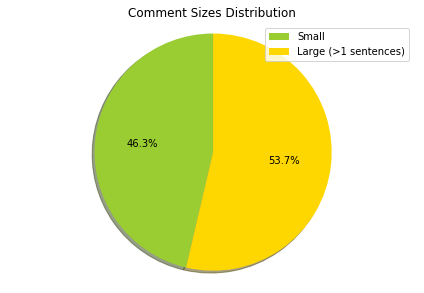

In [0]:
total = smallComments + largeComments
labels = ['Small', 'Large (>1 sentences)']
sizes = [smallComments/total, largeComments/total]
colors = ['yellowgreen', 'gold']
figure = plt.figure()
patches, texts, _ = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.title('Comment Sizes Distribution')
plt.show()

### Biggest String in the comments
#### Should be smaller than 64 words

In [0]:
bigString = max(allComments,key=len)

In [0]:
bigString.count(' ')

63

### Store comments for PreTraining BERT

In [0]:
with open('allRelevantCommentsUnannotatedEnglish_V02.txt', 'w') as f:
    for item in allComments:
        f.write("%s\n" % item)